In [1]:
# Running on GPU?
import setGPU

import getpass
import h5py
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib

from tqdm import tqdm

setGPU: Setting GPU to: 0


In [2]:
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [3]:
import json
import numpy as np
import pandas as pd

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [4]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 11

In [5]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/JetHT.json"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/cleaned_input_aggresive/"
model_name = "model"

In [6]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [7]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: JetHT_C_background
Reading: JetHT_D_background
Reading: JetHT_E_background
Reading: JetHT_F_background
Reading: JetHT_G_background
Reading: JetHT_H_background
Reading: JetHT_C_signal
Reading: JetHT_D_signal
Reading: JetHT_E_signal
Reading: JetHT_F_signal
Reading: JetHT_G_signal
Reading: JetHT_H_signal


In [8]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2807, 2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [9]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

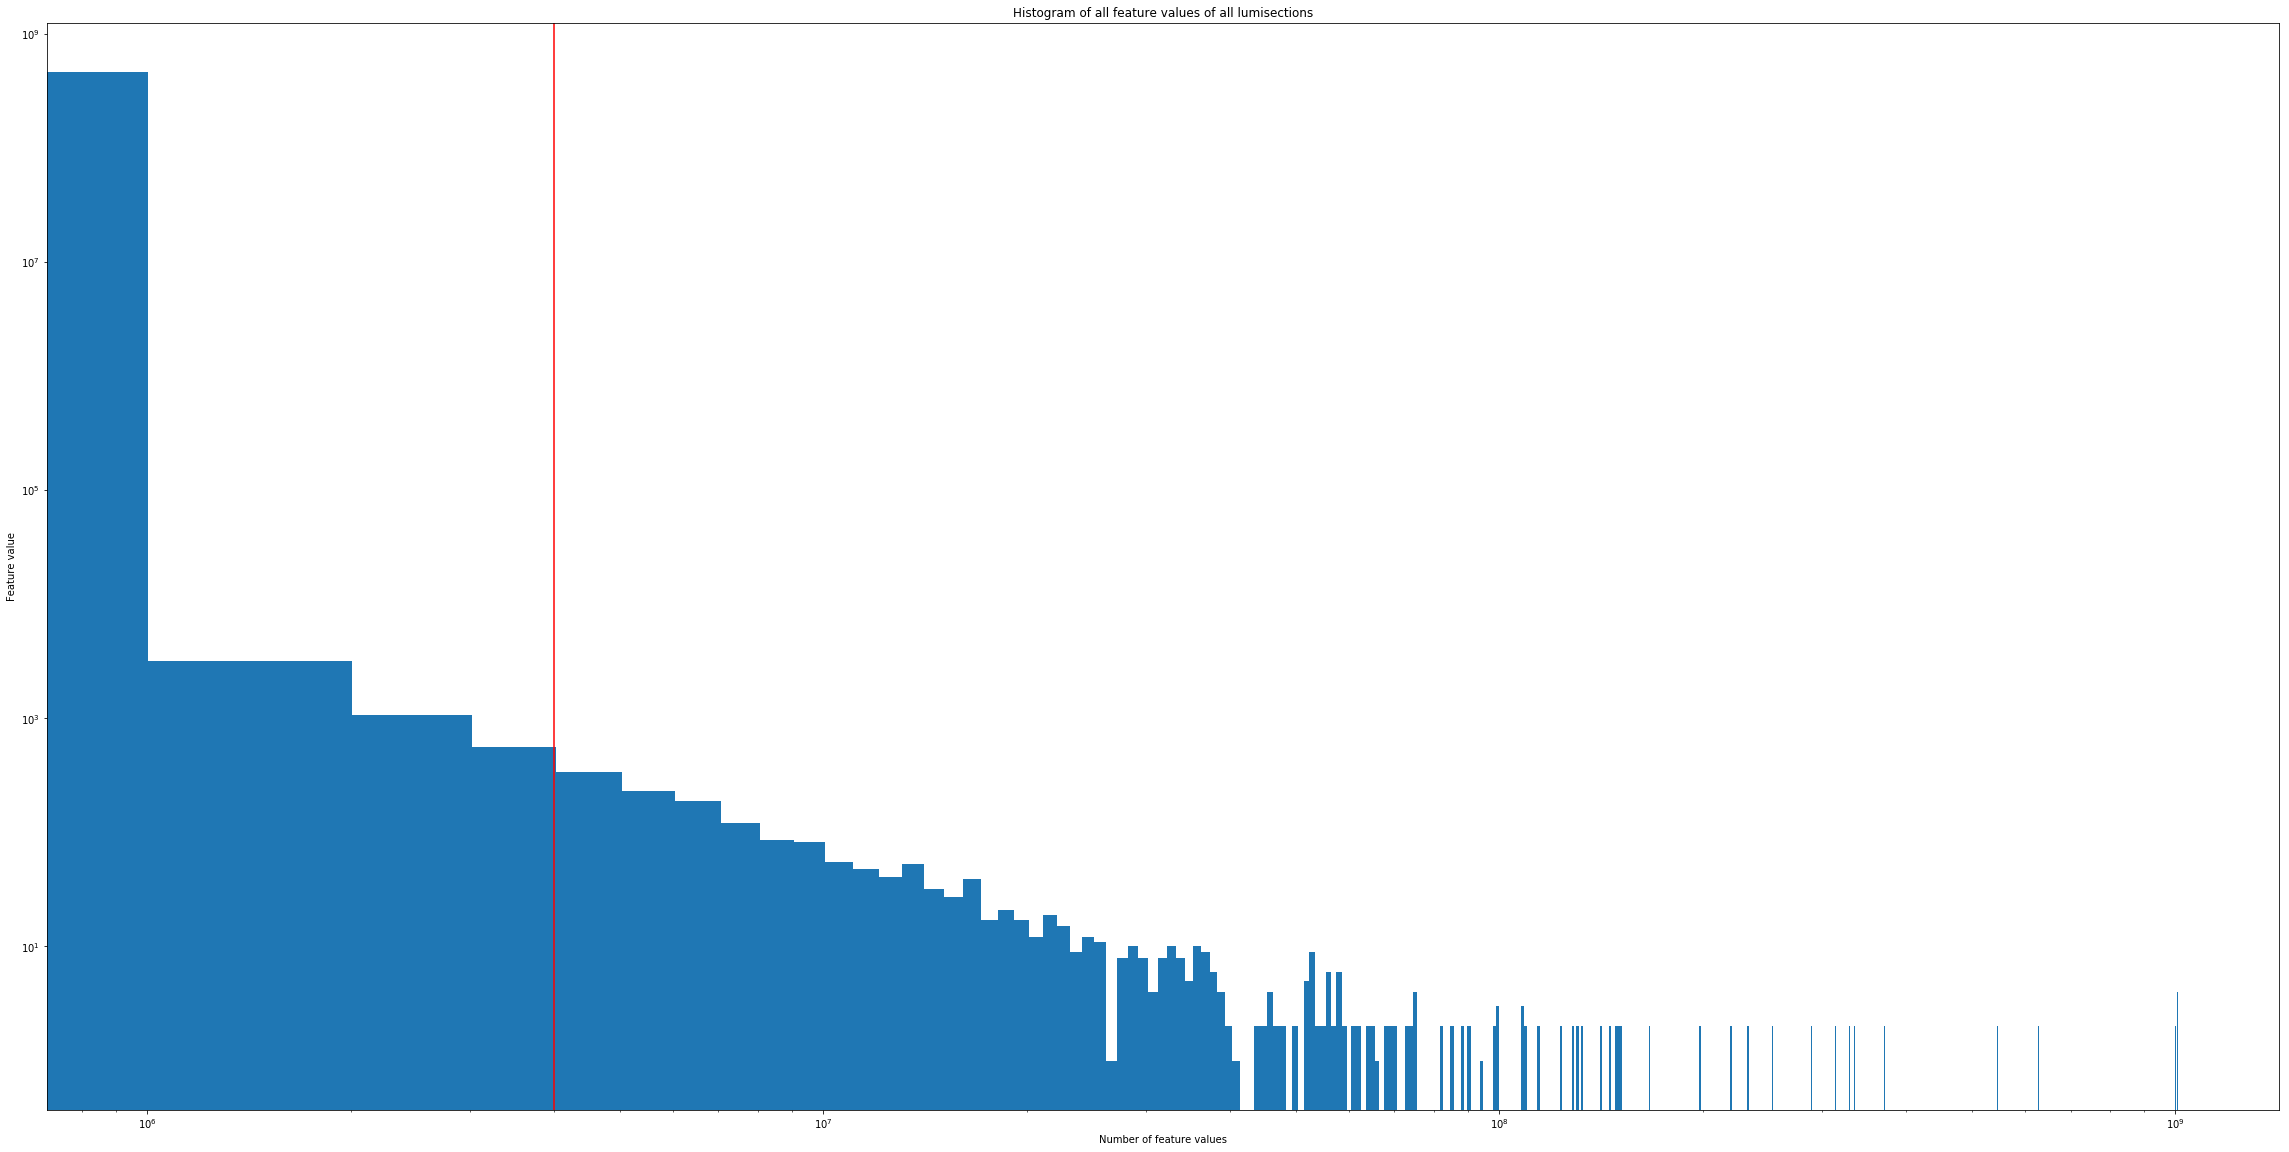

In [10]:
treshold = 4e6
plt.rcParams['figure.figsize'] = [40, 20]
plt.hist(data.iloc[:, :2807].values.reshape(-1), bins=1000)
plt.xscale('log')
plt.yscale('log')
plt.axvline(treshold, color='r')
plt.ylabel("Feature value")
plt.xlabel("Number of feature values")
plt.title("Histogram of all feature values of all lumisections")
plt.show()

In [11]:
data['keep'] = data.apply(lambda row: all([x < treshold for x in row]), axis = 1)

In [12]:
data[data['keep'] == False].shape

(662, 2812)

In [13]:
data_orig = data

In [14]:
# Split the data
SPLIT_FACTOR = 0.1

split = round(SPLIT_FACTOR*len(data))

runIDs = runIDs[split:]
lumiIDs = lumiIDs[split:]
luminosity = luminosity[split:]

train = data.iloc[:split]
before = train.shape[0]
train_orig = train
train = train[train['keep'] == True]
print("Removed: ", before - train.shape[0])
X_train = train.iloc[:, 0:2806]
y_train = train["label"]

test = data.iloc[split:]
X_test = test.iloc[:, 0:2806]
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

input_dim = X_train.shape[1]

Removed:  57


In [15]:
input_layer = Input(shape=(input_dim, ))

x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(500, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(2000, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(input_dim)(x)
x = linear(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2806)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              5614000   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2000)              2000      
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              2001000   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1000)              1000      
_________________________________________________________________
dense_3 (Dense)              (None, 500)               500500    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 500)               500       
__________

In [16]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [17]:
X_train = X_train.values
X_test = X_test.values

In [18]:
autoencoder.fit(X_train_norm,
                X_train_norm,
                epochs=128,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 11818 samples, validate on 3940 samples
Epoch 1/128
33s - loss: 74.8365 - val_loss: 63.4625
Epoch 2/128
3s - loss: 54.6668 - val_loss: 46.2872
Epoch 3/128
3s - loss: 39.7658 - val_loss: 33.5952
Epoch 4/128
3s - loss: 28.7489 - val_loss: 24.2227
Epoch 5/128
3s - loss: 20.6350 - val_loss: 17.3452
Epoch 6/128
3s - loss: 14.7027 - val_loss: 12.3412
Epoch 7/128
3s - loss: 10.4056 - val_loss: 8.7362
Epoch 8/128
3s - loss: 7.3265 - val_loss: 6.1703
Epoch 9/128
3s - loss: 5.1476 - val_loss: 4.3677
Epoch 10/128
3s - loss: 3.6285 - val_loss: 3.1234
Epoch 11/128
3s - loss: 2.5886 - val_loss: 2.2811
Epoch 12/128
3s - loss: 1.8937 - val_loss: 1.7268
Epoch 13/128
3s - loss: 1.4343 - val_loss: 1.3535
Epoch 14/128
3s - loss: 1.1213 - val_loss: 1.0987
Epoch 15/128
3s - loss: 0.9112 - val_loss: 0.9317
Epoch 16/128
3s - loss: 0.7758 - val_loss: 0.8256
Epoch 17/128
3s - loss: 0.6875 - val_loss: 0.7522
Epoch 18/128
3s - loss: 0.6248 - val_loss: 0.6998
Epoch 19/128
3s - loss: 0.5803 - val_loss: 0.6

In [19]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [20]:
# Run predictions
predictions = autoencoder.predict(X_test_norm)

def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
ae_error = get_error_df(X_test_norm, predictions, mode="topn")

In [21]:
ae_pred_baseline = pickle.load(open('/eos/user/t/tkrzyzek/autoencoder/lumi_dep/split01/ae_pred.p', "rb"))
ae_error_baseline = get_error_df(X_test_norm, ae_pred_baseline, mode="topn")

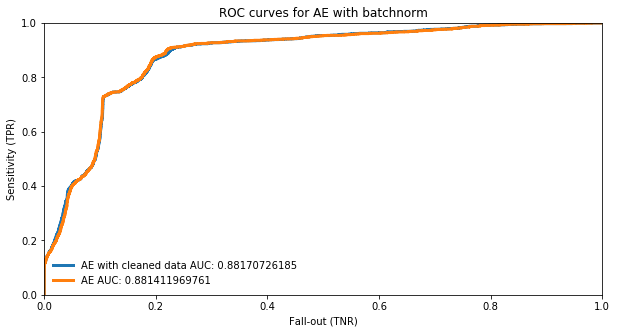

In [22]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, scores, names):
    """Generates ROC Curves for a given array"""
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 #linestyle=line_styles[0],
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.title('ROC curves for AE with batchnorm')
    plt.show();

plt.rcParams['figure.figsize'] = [10, 5]
get_roc_curve(y_test, [ae_error, ae_error_baseline], ['AE with cleaned data', 'AE'])

In [23]:
# model_directory = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/temp/"

In [24]:
# pickle.dump(ae_error, open(model_directory + "ae_error_cleaned_4e7.p", "wb"))

In [25]:
# pickle.dump(predictions, open(model_directory + "pred_cleaned_4e7.p", "wb"))

In [23]:
def pred_vs_feature2(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    x_lim=None, y_lim=None, title=""):

    fig, (ax1) = plt.subplots(1, 1, sharex=True)
    
    ax = [ax1]
    ax1.set_title(title)
    
    for i in range(1):
        df = pd.DataFrame({'y_val': y_val[i],
                           'x_val': x_val,
                           'y_class': y_class})

        groups = df.groupby('y_class')

        for name, group in groups:
            ax[i].plot(group.x_val, 
                    group.y_val,
                    color="r" if name == 1 else "g",
                    marker='o',
                    ms=2,
                    linestyle='',
                    label= "Bad" if name == 1 else "Good")

        for i in selected:
            ax[i].plot(x_val[i],
                    y_val[i],
                    color="g",
                    marker='o',
                    ms=4,
                    linestyle='')

        ax[i].legend()
        if not linear:
            ax[i].set_yscale('log')
        if x_lim:
            ax[i].set_xlim(x_lim[0], x_lim[1])
        if y_lim:
            ax[i].set_ylim(y_lim[0], y_lim[1])
        ax[i].set_ylabel(y_name[i])
        ax[i].grid()
    plt.xlabel(x_name)
   
    plt.show()

In [24]:
def plot_var(legend, ae_pred):
    for var in legend:
            print("###########################################################################")
            print(var['name'])
            print("###########################################################################")

            X_var = X[:, var['start'] : var['end']+1]
            ae_pred_var = ae_pred[:, var['start'] : var['end']+1]

            mean = np.mean(X_var, axis=1)
            mean_abs = np.mean(np.abs(X_var), axis=1)
            sd = np.std(X_var, axis=1)
            
            ae_mean = np.mean(ae_pred_var, axis=1)
            ae_mean_abs = np.mean(np.abs(ae_pred_var), axis=1)
            ae_sd = np.std(ae_pred_var, axis=1)

            # No scale set
            pred_vs_feature2([mean, mean_abs, sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " abs"],
                            "Luminosity",
                            title=var['name'],
                            x_lim=(0, 0.35),
#                             y_lim=(-5, 5),
                            linear=True)
            
            pred_vs_feature2([ae_mean, ae_mean_abs, ae_sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " AE pred"],
                            "Luminosity",
                            title=var['name'] + " AE pred",
                            x_lim=(0, 0.35),
#                             y_lim=(-5, 5),
                            linear=True)
            
            # With bounds [-5, 5]
            pred_vs_feature2([mean, mean_abs, sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " abs"],
                            "Luminosity",
                            title=var['name'],
                            x_lim=(0, 0.35),
                            y_lim=(-5, 5),
                            linear=True)
            
            pred_vs_feature2([ae_mean, ae_mean_abs, ae_sd],
                            luminosity, 
                            y_test, #!!!
                            [var['name'], 
                             var['name'] + " AE pred"],
                            "Luminosity",
                            title=var['name'] + " AE pred",
                            x_lim=(0, 0.35),
                            y_lim=(-5, 5),
                            linear=True)


In [25]:
# start_legend = 1918 #nvtx
start_legend = 1414

In [26]:
var_legend = [{'start': start_legend, 'end': start_legend, 'name': 'Mean'},
              {'start': start_legend+1, 'end': start_legend+1, 'name': 'RMS'},
              {'start': start_legend+2, 'end': start_legend+2, 'name': 'Q1'},
              {'start': start_legend+3, 'end': start_legend+3, 'name': 'Q2'},
              {'start': start_legend+4, 'end': start_legend+4, 'name': 'Q3'},
              {'start': start_legend+5, 'end': start_legend+5, 'name': 'Q4'},
              {'start': start_legend+6, 'end': start_legend+6, 'name': 'Q5'}]

In [27]:
X = X_test

###########################################################################
Mean
###########################################################################


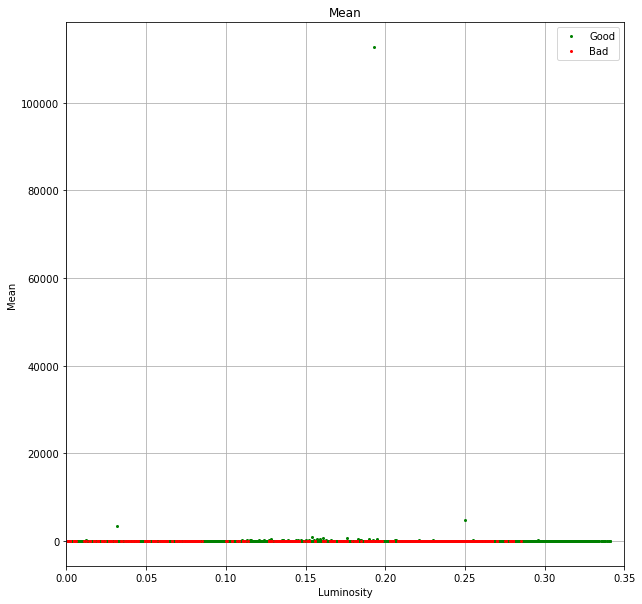

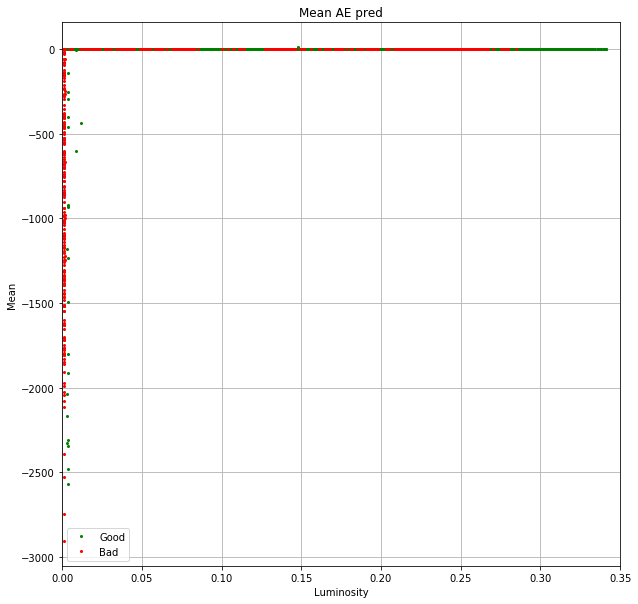

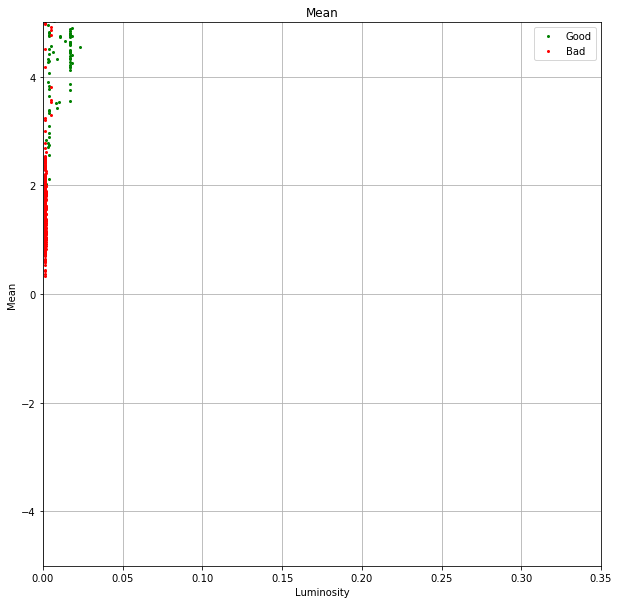

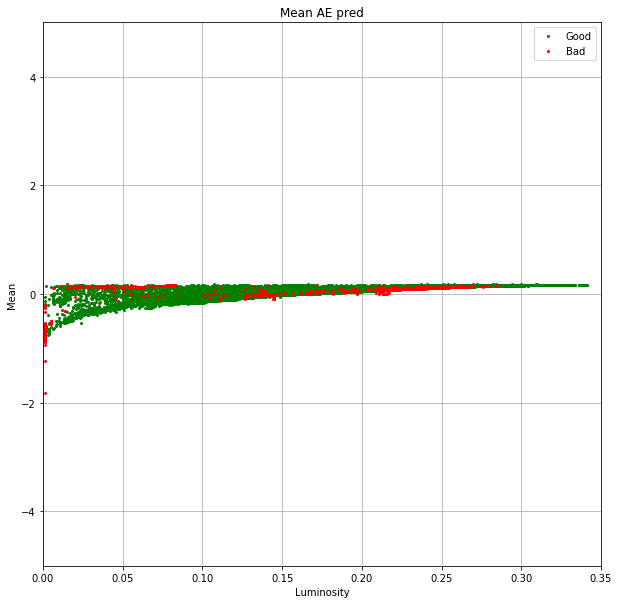

###########################################################################
RMS
###########################################################################


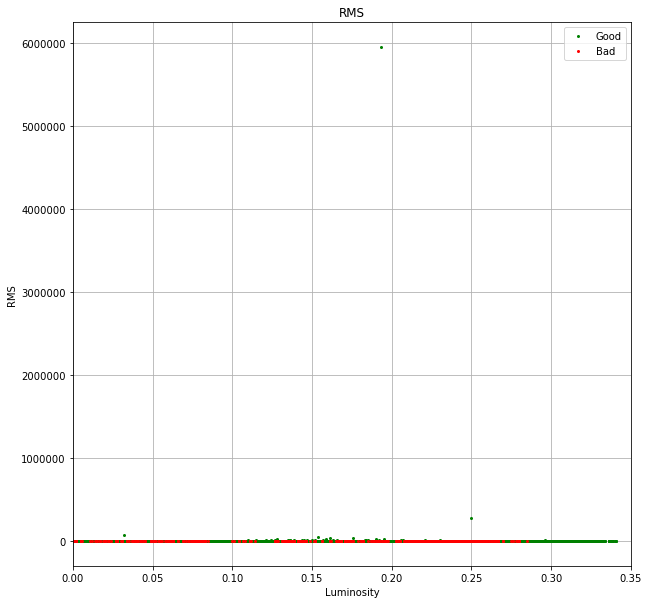

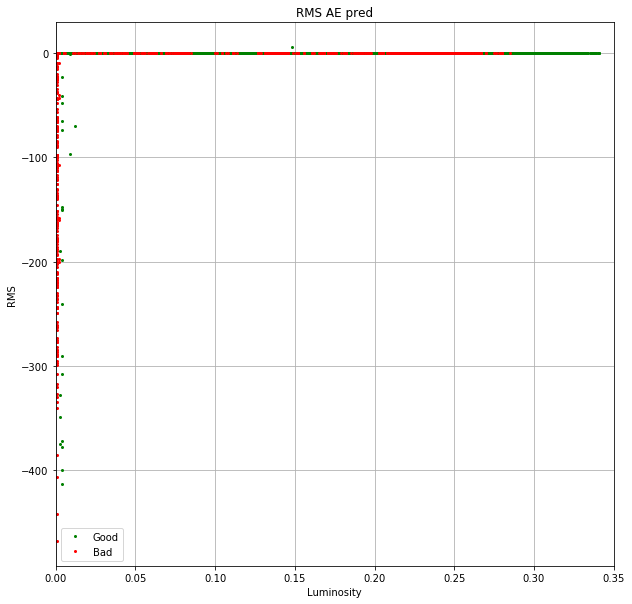

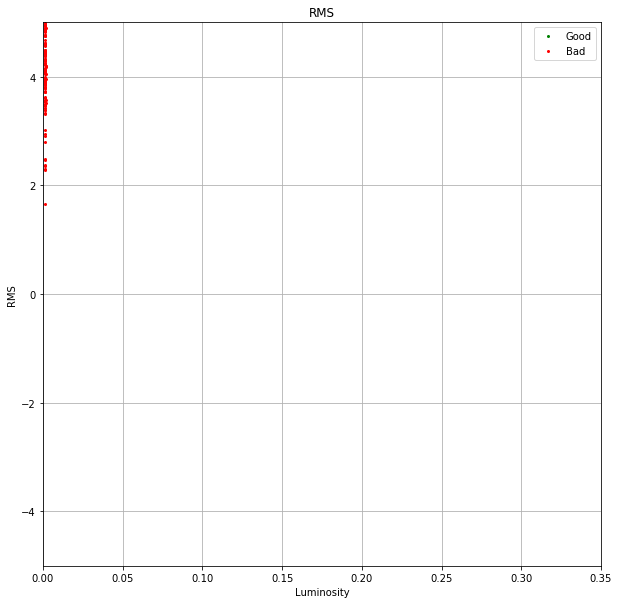

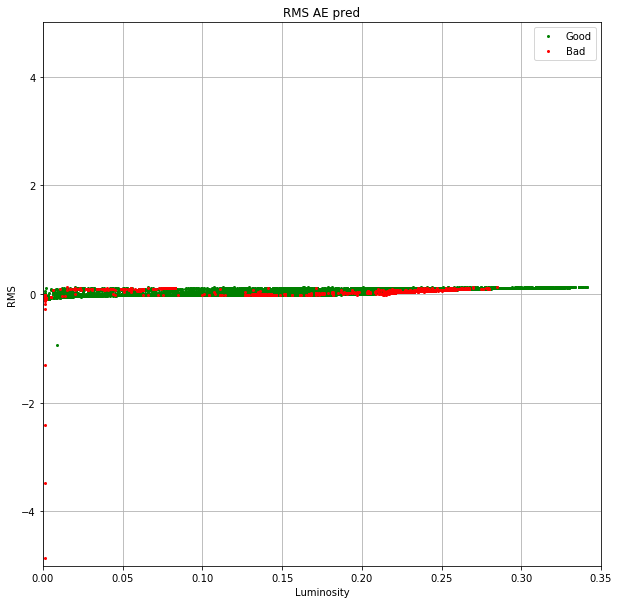

###########################################################################
Q1
###########################################################################


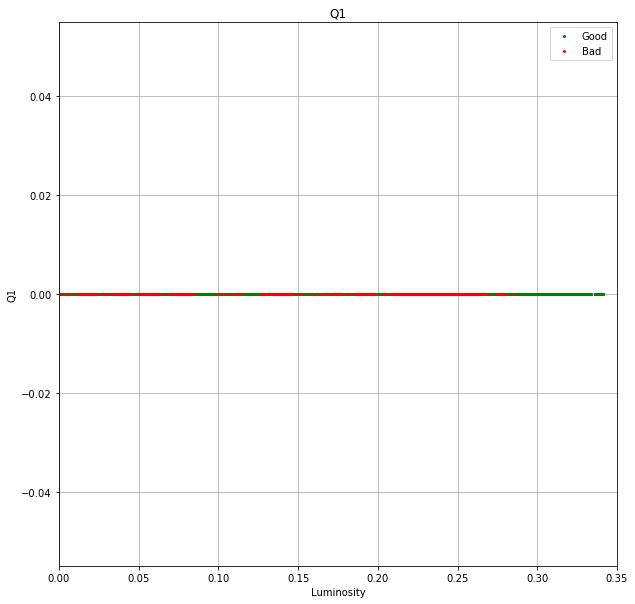

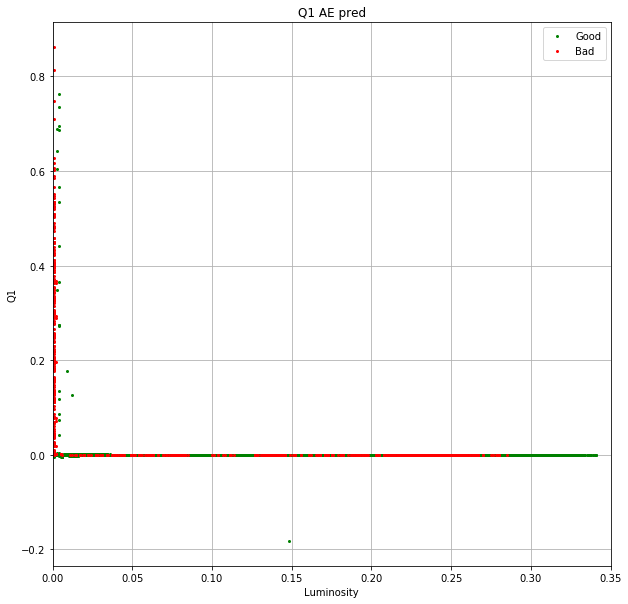

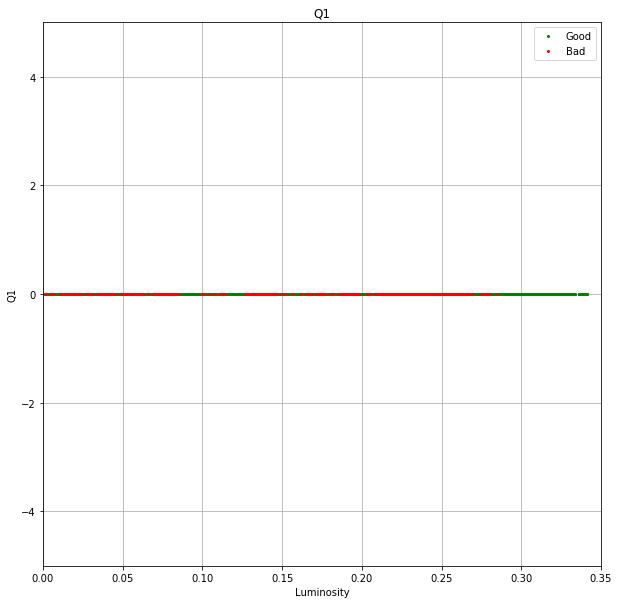

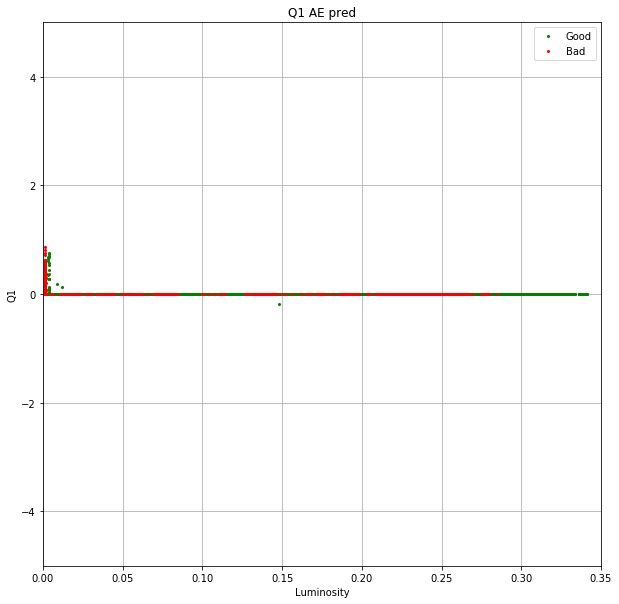

###########################################################################
Q2
###########################################################################


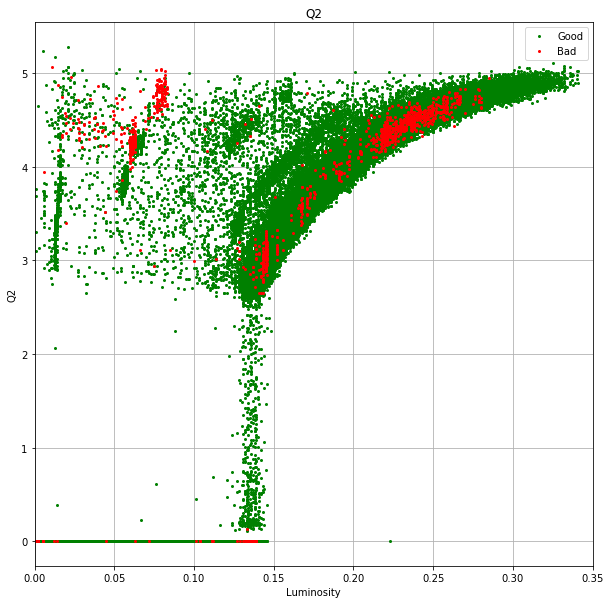

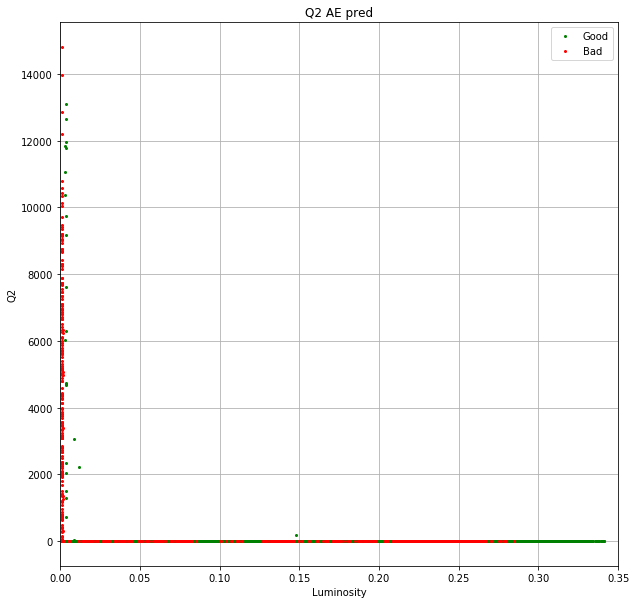

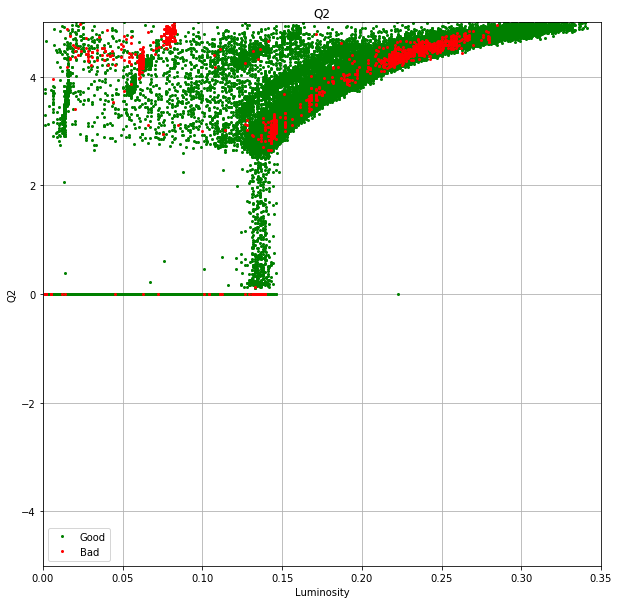

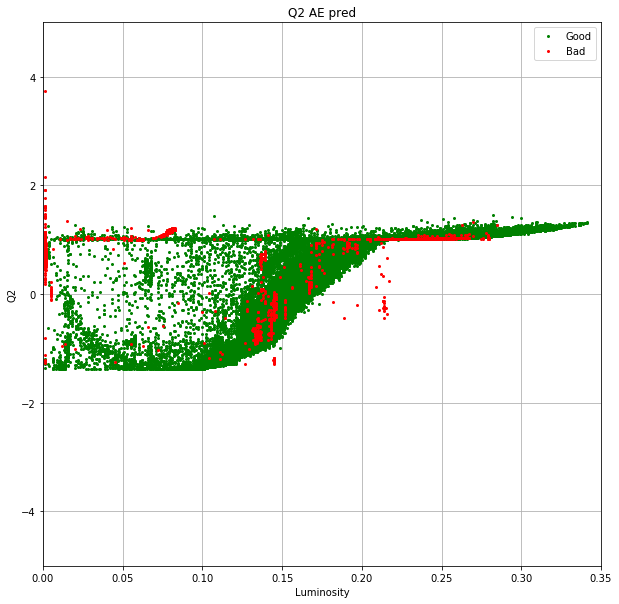

###########################################################################
Q3
###########################################################################


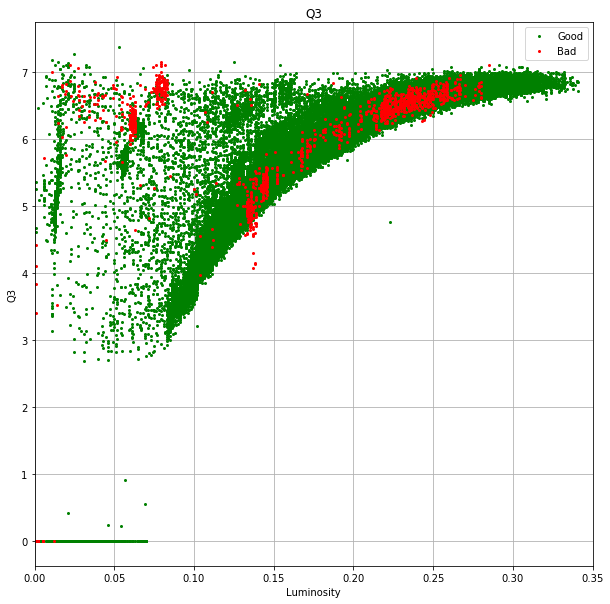

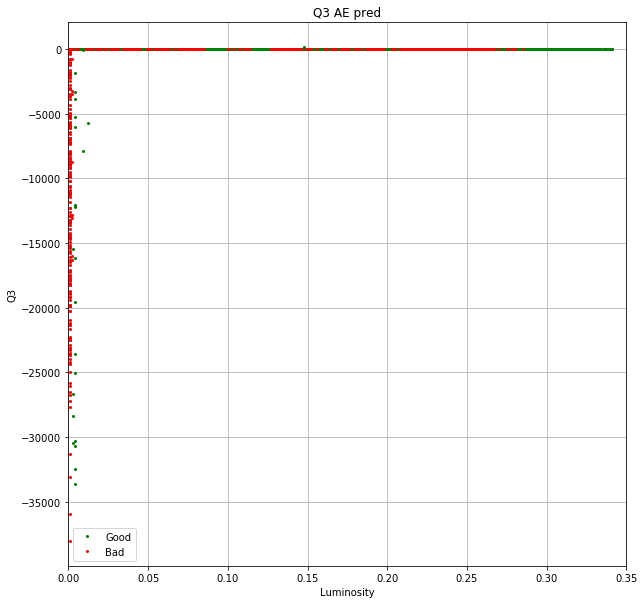

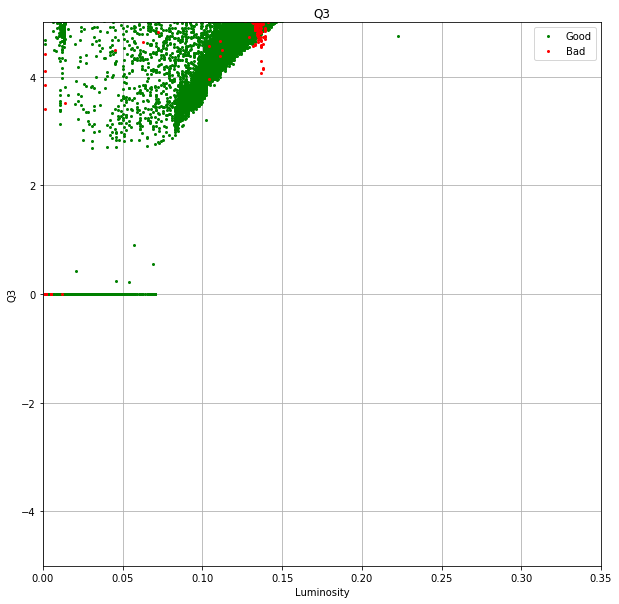

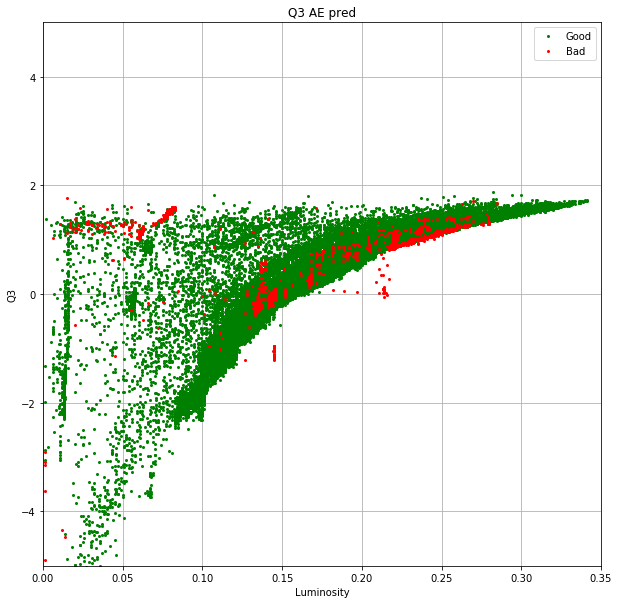

###########################################################################
Q4
###########################################################################


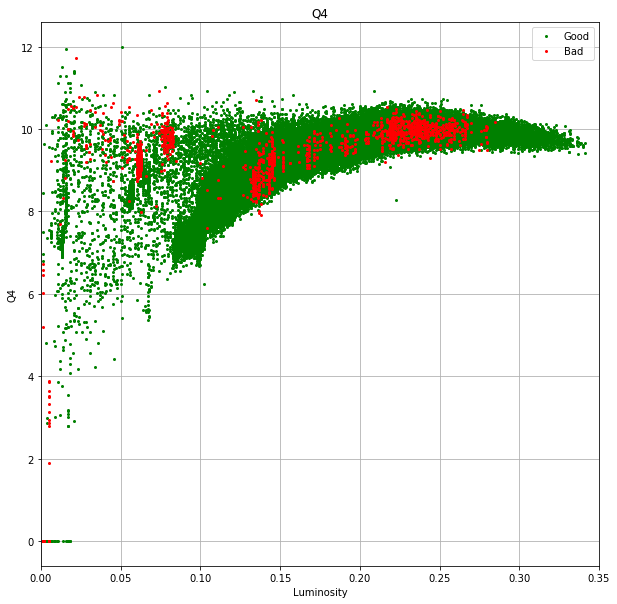

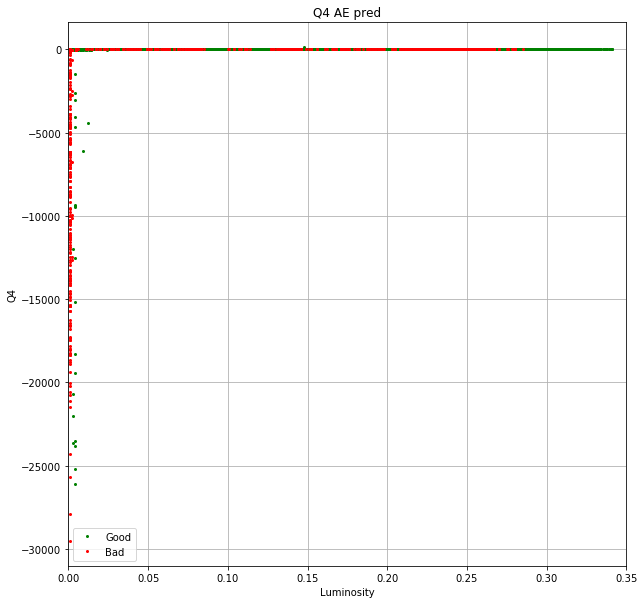

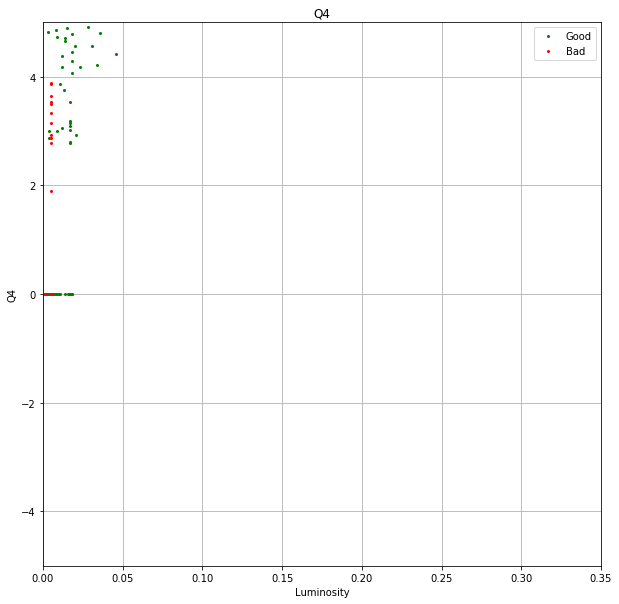

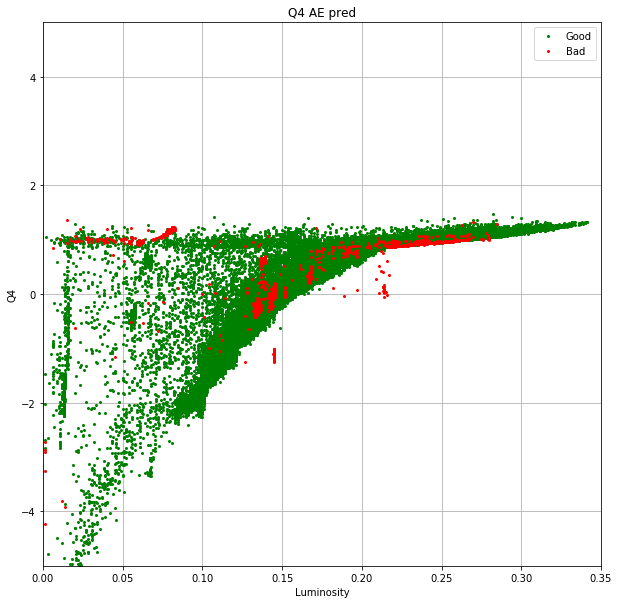

###########################################################################
Q5
###########################################################################


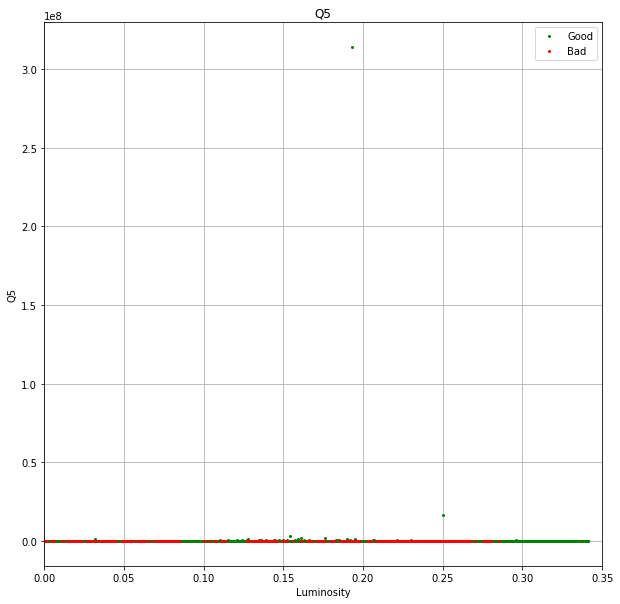

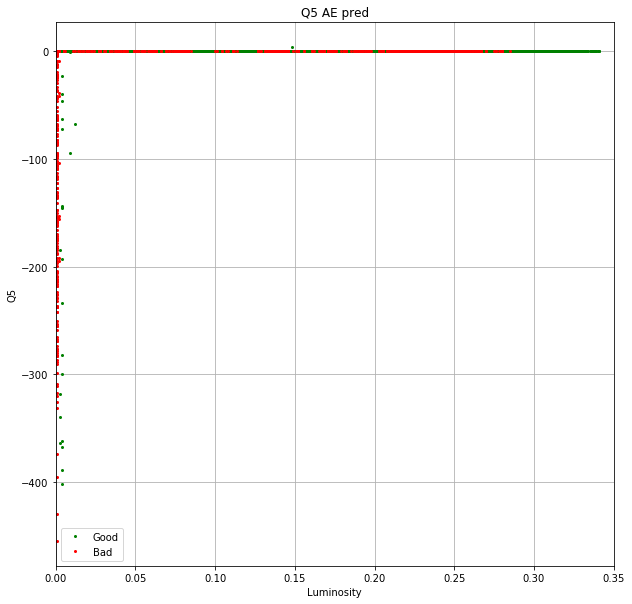

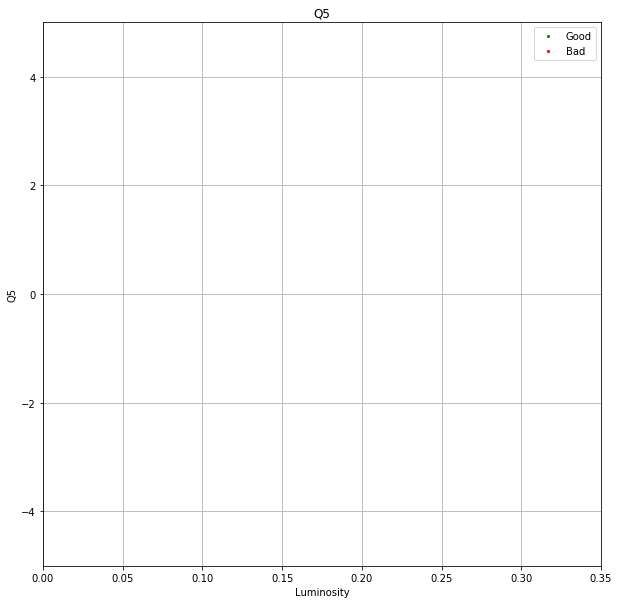

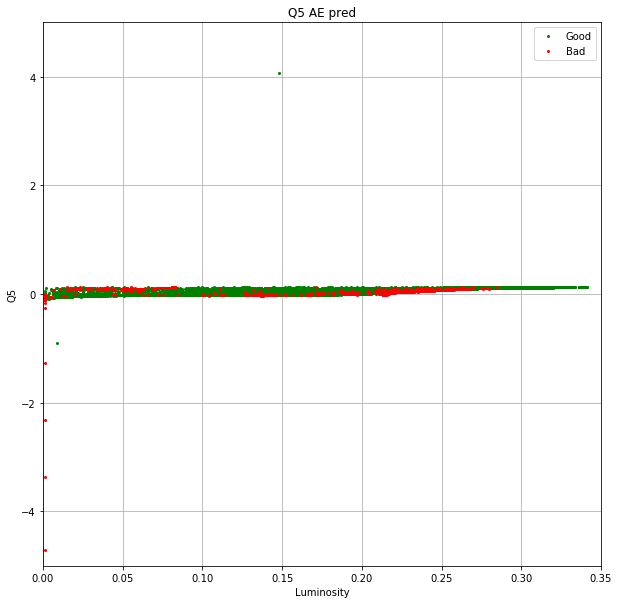

In [28]:
matplotlib.rcParams["figure.figsize"] = (10, 10)
plot_var(var_legend, predictions)